In [257]:
import json
import glob
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import statistics
import numpy as np

In [294]:
eval_files_list = glob.glob('eval_results*.json')

In [295]:
def get_data(eval_file_path):
    with open(eval_file_path, 'r') as f:
        data = json.loads(f.read())
    eval_data = {}
    eval_data["iteration"] = data["config"]["model_args"]["iteration"]
    eval_data["model_name"] = list(data["config"]["model_args"]["config_files"].keys())[0][:-4]
    eval_data["templates"] = tuple(set(data["table_results"][res]["prompt_name"] for res in data["table_results"].keys()))
    eval_data["tasks"] = tuple(set(data["table_results"][res]["task_name"] for res in data["table_results"].keys()))
    dct = defaultdict(list)
    for key, value in data["table_results"].items():
        task, template = key.split("+")
        dct[task].append((template, value["em"], value["em_stderr"]))
        #dct[template].append((task, value["em"], value["em_stderr"]))
    for template, value in dct.items():
        inner_dict = {}
        for task, em, em_stderr in value:
            inner_dict[task] = (em, em_stderr)
        dct[template] = inner_dict
    eval_data["results"] = dct
    return eval_data

In [296]:
data_lst = [get_data(eval_file) for eval_file in eval_files_list]

In [304]:
tasks = ["wino_bias_type1_pro", "wino_bias_type1_anti", "wino_bias_type2_pro", "wino_bias_type2_anti"]
templates = ["What does p stand for", "refers_to"]
bb_iterations = sorted([eval["iteration"] for eval in data_lst if eval["model_name"] == "pythia-350M"])
sb_iterations = [3000, 13000, 23000, 33000, 43000, 53000, 63000, 73000, 83000, 93000, 103000, 113000, 123000, 133000, 143000]
bb_percents = ["{:.0f}".format((iter / bb_iterations[-1]) * 100) for iter in bb_iterations]
sb_percents = ["{:.0f}".format((iter / sb_iterations[-1]) * 100) for iter in sb_iterations]

In [298]:
set(sb_iterations) - set([eval["iteration"] for eval in data_lst if eval["model_name"] == "pythia-19M"])

{13000, 123000}

In [299]:
for eval in data_lst:
    if eval["model_name"] == "pythia-19M":
        print(eval["iteration"], eval["templates"], eval["tasks"])

33000 ('What does p stand for', 'refers_to') ('wino_bias_type2_anti', 'wino_bias_type1_anti', 'wino_bias_type2_pro', 'wino_bias_type1_pro')
73000 ('What does p stand for', 'refers_to') ('wino_bias_type2_anti', 'wino_bias_type1_anti', 'wino_bias_type2_pro', 'wino_bias_type1_pro')
83000 ('What does p stand for', 'refers_to') ('wino_bias_type2_anti', 'wino_bias_type1_anti', 'wino_bias_type2_pro', 'wino_bias_type1_pro')
43000 ('What does p stand for', 'refers_to') ('wino_bias_type2_anti', 'wino_bias_type1_anti', 'wino_bias_type2_pro', 'wino_bias_type1_pro')
113000 ('What does p stand for', 'refers_to') ('wino_bias_type2_anti', 'wino_bias_type1_anti', 'wino_bias_type2_pro', 'wino_bias_type1_pro')
53000 ('What does p stand for', 'refers_to') ('wino_bias_type2_anti', 'wino_bias_type1_anti', 'wino_bias_type2_pro', 'wino_bias_type1_pro')
3000 ('What does p stand for', 'refers_to') ('wino_bias_type2_anti', 'wino_bias_type1_anti', 'wino_bias_type2_pro', 'wino_bias_type1_pro')
23000 ('What does p 

In [300]:
def eval_model_size(model_size):
    # return dict is a dict of dicts, where the first keys are the iterations
    # and the second keys are "type1" and "type2"
    proc_dct = {}
    final_results = {}
    for eval in data_lst:
        iteration = eval["iteration"]
        proc_dct[iteration] = {
            task: {} for task in tasks
        }
        if eval["model_name"] == f"pythia-{model_size}":
            for task, result_dct in eval["results"].items():
                mean = statistics.fmean([result_dct[template][0] for template in templates])
                std = math.sqrt(statistics.mean([result_dct[template][1]**2 for template in templates]))
                proc_dct[iteration][task] = (mean, std)
                # for template in templates:
                #     em_diff = result_dct[task + "_pro"][0] - result_dct[task + "_anti"][0]
                #     # Std of difference is sqrt(sum of variances)
                #     em_std = math.sqrt(result_dct[task + "_pro"][1]**2 + result_dct[task + "_anti"][1]**2)
                #     proc_dct[iteration][template][task] = (em_diff, em_std, result_dct[task + "_pro"][0], result_dct[task + "_anti"][0])
            type1_diff = proc_dct[iteration]["wino_bias_type1_pro"][0] - proc_dct[iteration]["wino_bias_type1_anti"][0]
            # Std of difference is sqrt(sum of variances)
            type1_err = math.sqrt(proc_dct[iteration]["wino_bias_type1_pro"][1]**2 + proc_dct[iteration]["wino_bias_type1_anti"][1]**2)
            type1_pro, type1_anti = proc_dct[iteration]["wino_bias_type1_pro"][0], proc_dct[iteration]["wino_bias_type1_anti"][0]
            type2_diff = proc_dct[iteration]["wino_bias_type2_pro"][0] - proc_dct[iteration]["wino_bias_type2_anti"][0]
            type2_err = math.sqrt(proc_dct[iteration]["wino_bias_type2_pro"][1]**2 + proc_dct[iteration]["wino_bias_type2_anti"][1]**2)
            type2_pro, type2_anti = proc_dct[iteration]["wino_bias_type2_pro"][0], proc_dct[iteration]["wino_bias_type2_anti"][0]
            type1 = (type1_diff, type1_err, type1_pro, type1_anti)
            type2 = (type2_diff, type2_err, type2_pro, type2_anti)
                
            final_results[iteration] = {
                "type1": type1,
                "type2": type2 
            }
    return final_results

In [236]:
all_results = {
    #"19M": {},
    "350M": {},
    "1.3B": {}
}
for size in all_results.keys():
    all_results[size] = eval_model_size(size)

In [327]:
def get_lists_for_plotting(model_size, type):
    res_lists = {
        "diffs": [],
        "errs": [],
        "pro": [],
        "anti": [],
    }
    if model_size == "19M" or model_size == "6.7B":
        iterations = sb_iterations
        iter_percents = sb_percents
    else:
        iterations = bb_iterations
        iter_percents = bb_percents
    for iteration in iterations:
        diff, err, pro_em, anti_em = all_results[model_size][iteration][type]
        res_lists["diffs"].append(diff)
        res_lists["errs"].append(err)
        res_lists["pro"].append(pro_em)
        res_lists["anti"].append(anti_em)
    res_lists["iter_percents"] = iter_percents
    return res_lists

Text(0.5, 1.0, 'Winobias')

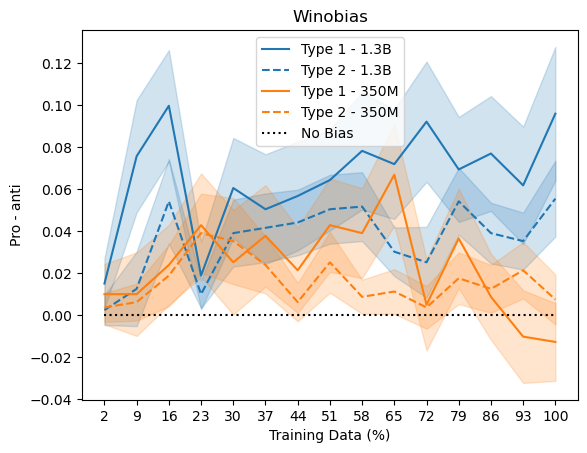

In [314]:
iter_percents, (diffs, errs, pro, anti) = get_lists_for_plotting("1.3B", "type1")
plt.plot(iter_percents, diffs, label = "Type 1 - 1.3B", color="C0")
plt.fill_between(iter_percents, [diff - err for diff, err in zip(diffs, errs)], [diff + err for diff, err in zip(diffs, errs)], 
                 alpha=0.2, color="C0")
iter_percents, (diffs, errs, pro, anti) = get_lists_for_plotting("1.3B", "type2")
plt.plot(iter_percents, diffs, label="Type 2 - 1.3B", linestyle="--", color="C0")
plt.fill_between(iter_percents, [diff - err for diff, err in zip(diffs, errs)], [diff + err for diff, err in zip(diffs, errs)], 
                 alpha=0.2, color="C0")

iter_percents, (diffs, errs, pro, anti) = get_lists_for_plotting("350M", "type1")
plt.plot(iter_percents, diffs, label = "Type 1 - 350M", color="C1")
plt.fill_between(iter_percents, [diff - err for diff, err in zip(diffs, errs)], [diff + err for diff, err in zip(diffs, errs)], 
                 alpha=0.2, color="C1")
iter_percents, (diffs, errs, pro, anti) = get_lists_for_plotting("350M", "type2")
plt.plot(iter_percents, diffs, label="Type 2 - 350M", linestyle="--", color="C1")
plt.fill_between(iter_percents, [diff - err for diff, err in zip(diffs, errs)], [diff + err for diff, err in zip(diffs, errs)],
                 alpha=0.2, color="C1")

plt.plot(iter_percents, [0 for _ in iter_percents], linestyle=":", color="black", label="No Bias")

plt.legend()
plt.xlabel("Training Data (%)")
#plt.ylim(-0.1, 0.1)
plt.ylabel("Pro - anti")
plt.title("Winobias")
#plt.savefig("winobias.png")

Text(0.5, 1.0, 'Winobias')

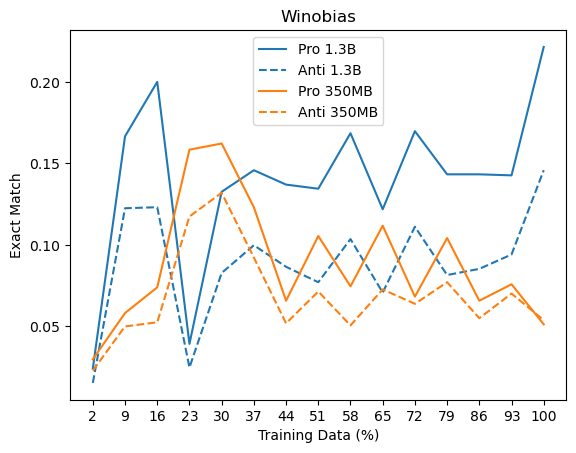

In [330]:
type1_1_3B = get_lists_for_plotting("1.3B", "type1")
type2_1_3B = get_lists_for_plotting("1.3B", "type2")
pro_1_3b = np.mean(np.asarray([type1_1_3B["pro"], type2_1_3B["pro"]]), axis=0)
anti_1_3b = np.mean(np.asarray([type1_1_3B["anti"], type2_1_3B["anti"]]), axis=0)
type1_350M = get_lists_for_plotting("350M", "type1")
type2_350M = get_lists_for_plotting("350M", "type2")
pro_350m = np.mean(np.asarray([type1_350M["pro"], type2_350M["pro"]]), axis=0)
anti_350m = np.mean(np.asarray([type1_350M["anti"], type2_350M["anti"]]), axis=0)
plt.plot(type1_1_3B["iter_percents"], pro_1_3b, label = "Pro 1.3B", color="C0")
plt.plot(type1_1_3B["iter_percents"], anti_1_3b, label = "Anti 1.3B", color="C0", linestyle="--")

plt.plot(type1_350M["iter_percents"], pro_350m, label = "Pro 350MB", color="C1")
plt.plot(type1_350M["iter_percents"], anti_350m, label = "Anti 350MB", color="C1", linestyle="--")

plt.legend()
plt.xlabel("Training Data (%)")
plt.ylabel("Exact Match")
plt.title("Winobias")
#plt.savefig("winobias_em.png")